## Task C

### U-net
U-Net was first proposed for Biomedical Image Segmentation. One of the main advantages of using U-Net is its ability to yield relatively good results on pixel-labelling tasks with limited dataset images.

### Image segmentation
This task focuses on the task of image segmentation, using a modified U-Net.

### What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as transform
from tqdm.notebook import tqdm
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 1.1 loading dataset

In [ ]:
train_dir = glob("./drive/MyDrive/dataset1/train/*") # train dataset
val_dir = glob("./drive/MyDrive/dataset1/val/*")   # validation dataset

print(len(train_dir), len(val_dir))

### 1.2 showing a sample

./drive/MyDrive/dataset1/train/2916.jpg


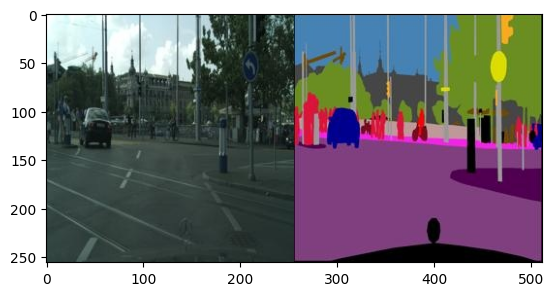

In [ ]:
sample_image_fp = os.path.join(train_dir[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

### 2. Defining Custom Dataset

In [ ]:
train_dataset = []
validation_dataset = []

In [ ]:
class MyDataset(Dataset):

    def __init__(self, images_path ,transform_img=None ,transform_label=None):

        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):

        img = plt.imread(self.images_path[idx])
        image,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

###3 Defining the Transfoms

In [ ]:
mytransformsImage = transform.Compose(
    [
        transform.ToTensor(),
        #transform.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transforms.RandomHorizontalFlip(p=0.9)
    ]
)

mytransformsLabel = transform.Compose(
    [
        transform.ToTensor(),
    ]
)

In [ ]:
# train dataset

#your code
traindata = MyDataset(train_dir , mytransformsImage , mytransformsLabel)
# val dataset
valdata = MyDataset(val_dir , mytransformsImage , mytransformsLabel)
#end


In [ ]:
# Creating the DataLoaders
batch_size = 4
train_loader = DataLoader(traindata,batch_size)
vaild_loader = DataLoader(valdata,1)


In [ ]:
'''
    This is a helper function.
    This will help in ploting the masked got from the model.

'''
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(10,10))

    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

###4. Building UNet Model Architecture

### 4.1
This Module representes the individual horizontal conv block layers in the Unet Model. And you need to do the following steps.
* 1-Conv()
* 2-BatchNorm()
* 3- ReLU()
* 4-Conv()
* 5-ReLU()
kernel size = 3 padding = 1 stride = 1


In [ ]:

'''

    This Module representes the individual horizontal conv block layers in the Unet Model.
    Conv() -> BatchNorm() -> ReLU() -> Conv() -> ReLU()

'''

class Convblock(nn.Module):

      def __init__(self,input_channel,output_channel,kernel=3,stride=1,padding=1):

        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel , output_channel , kernel , stride , padding),

            nn.BatchNorm2d(output_channel) ,

            nn.ReLU() ,

            nn.Conv2d(output_channel,output_channel , kernel , stride , padding) ,

            nn.ReLU()
            #end
        )



      def forward(self,x):
        #your code
        x = self.convblock()(x)
        #end
        return x


### 4.2
Write the appropriate code instead of the parts where the 'None' is placed.

In [ ]:
# Encoder -> BottelNeck => Decoder
class UNet(nn.Module):

    def __init__(self,input_channel,retain=True):

        super().__init__()
        #encoder
        self.conv1 = Convblock(input_channel , 32)  #input
        self.conv2 = Convblock(32, 64)          #first block 32
        self.conv3 = Convblock(64 , 128)          #block two 64
        self.conv4 = Convblock(128 , 512)          #block three 128


        # neck

        self.neck=nn.Conv2d(512 , 512 , 3 , 1)          #neck 256 kernet_size=3 stride=1 use conv2d


        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(256,256)  #conveblock

        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(128,128)  #conveblock

        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(64,64)    #conveblock

        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(32,32) #conveblock

        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain

    def forward(self,x):

        # Encoder Network

        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = nn.MaxPool2d(2,2)(conv1)    #kerner_size =2 stride=2
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = nn.MaxPool2d(2,2)(conv2)    #kerner_size =2 stride=2
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = nn.MaxPool2d(2,2)(conv3)   #kerner_size =2 stride=2
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = nn.MaxPool2d(2,2)(conv4)    #kerner_size =2 stride=2

        # BottelNeck
        neck = self.neck(pool4)

        # Decoder Network

        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(croped)
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(croped)
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(croped)
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(croped)
        # Output Layer
        out = self.out(None)

        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out

    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)

### 5. Initializing the model
* lr = 0.01
* epoch = 30
* loss function = MSE
* optimizer = Adam

In [ ]:
# initializing the model
model = UNet(3).float().to(device)

In [ ]:
lr = 0.01
epochs = 30

In [ ]:
# Choosing the loss function to be Mean Square Error Loss
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_acc = []
val_acc = []
train_loss = []
val_loss = []

### 6. training the model

In [ ]:
for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()     #clear gradient for next train
        img = img.to(device)
        label = label.to(device)
        output = model(img) # predict

        loss = lossfunc(output , label) #compute loss
        loss.backward()   #backpropagation
        optimizer.step()    #apply gradients

        trainloss+=loss.item()

    if(i%5==0):
        show(img,output,label)

    train_loss.append(trainloss/len(train_loader))

    for img,label in tqdm(vaild_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(vaild_loader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

  0%|          | 0/744 [00:00<?, ?it/s]

KeyboardInterrupt: ignored